## Proyecto 2 - Visión por computadora
 
Isabela Cáceres & David Alsina

En el presente notebook, se propone un algoritmo para segmentar imágenes 

In [1]:
#para trabajar la imagen :D
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy

#para paralelizar
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

#para analizar la señal del histograma
import scipy.signal as signal7w7

In [2]:
#numero de nucleos disponibles
num_cores = multiprocessing.cpu_count()

Como ejemplo se usará la imagen de una célula vegetal

(978, 922)

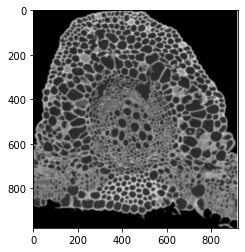

In [3]:
img = cv2.imread('planta_celula.png')

# quitamos algunas componentes de ruido con un filtro de media 
# y tamaño de kernel 3x3
img = cv2.medianBlur(img, 3)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap='gray')
img.shape

Primero generamos unas funciones que permitan construir elementos estructurales circulares. Esto es para poder detectar correctamente las formas.

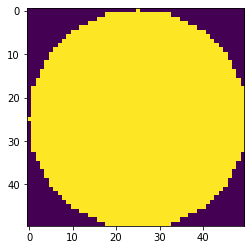

In [4]:
def gen_ones_circle(size):
    h = size
    A = np.zeros((h,h))
    c = h//2
    #print(c)
    for i in range(h):
        for j in range(h):
            k = np.linalg.norm(np.array([i,j]) - np.array([c,c]))
            if k <= c:
                A[i,j]=1
    return A

plt.imshow(gen_ones_circle(50));

Ahora hacemos nuestras funciones de dilatación y erosión.

In [5]:
def erosion(img, b):

    """
    Función hace el proceso de erosión

    img: imagen original
    b: elemento estructural
    """

    img_copy = copy.deepcopy(img)
    row, col = img.shape
    rowb, colb = b.shape
    st = (b == 1)
    
    for x in range(rowb//2, row-rowb//2):
        for y in range(colb//2, col-colb//2):
            img_copy[x][y] = np.min((img[x - rowb//2:x + rowb//2 + 1, y - colb//2:y + colb//2 + 1])[st])

    return img_copy

In [6]:
def dilatacion(img, b):

    """
    Función hace el proceso de dilatación

    img: imagen original
    b: elemento estructural
    """

    img_copy = copy.deepcopy(img)
    row, col = img.shape
    rowb, colb = b.shape
    b = np.flip(b, axis=0)
    b = np.flip(b, axis=1)
    st = (b == 1)
    
    for x in range(rowb//2, row-rowb//2):
        for y in range(colb//2, col-colb//2):
            img_copy[x][y] = np.max((img[x - rowb//2:x + rowb//2 + 1, y - colb//2:y + colb//2 + 1])[st])

    return img_copy

Basado en dilatación y erosión hacemos apertura y cerradura.

In [7]:
def opening(img:np.ndarray, b: np.array):
    
    """
    Función que hace apertura

    img: imagen original
    b: elemento estructural
    """
    return dilatacion(erosion(img, b), b)

In [8]:
def closing(img:np.ndarray, b: np.array):
    
    """
    Función que hace cierra

    img: imagen original
    b: elemento estructural
    """

    return erosion(dilatacion(img, b), b)

In [9]:
def granularidad(img, b ):
    #img, b = data
    size = b.shape[0]
    image = cv2.copyMakeBorder(img, size, size,
                               size, size,
                               cv2.BORDER_CONSTANT, None, value = 0)
    return closing(image, b)[size:-size, size:-size]

Acontinuación desarrollamos nuestra función para crear el histograma y detectarle los picos, el histograma se crea de la siguiente manera: 

Hacemos apertura a la imagen basados en un elemento estructural $b$ que es de forma circular. Después tomamos la imagen con apertura y la original y hacemos lo siguiente:

$$
imagen_{diferencia} = | imagen_{original} - imagen_{aperturada}|
$$

De esta imagen hacemos una suma de todos los valores de las entradas, con la intención de sacar una "activación" para la imagen. Con esto y variando los tamaños de elementos estructurales $b$, generamos un histograma de activación vs tamaño de $b$.

In [10]:
def area_histogram(img: np.ndarray,
                   min_b: int,
                   max_b: int,
                   step_sz: int):

    """
        img:     Imagen original.
        min_b:   Minimo diámetro por el cual empezar a generar 
                 elementos estructurales. 
        max_b:   Diámetro máximo a generar para los elementos 
                 estructurales.
        step_sz: Tamaño de paso desde min_b, hasta max_b
    """
    
    
    # vector con los distintos tamaños desde  min_b
    # hasta max_b
    b_sizes = np.arange(min_b, max_b, step_sz)
    
    # vector que contiene la suma de las intensidades
    # de cada imagen que se va procesando
    values = np.zeros(b_sizes.shape[0])

    #envía el proceso en paralelo para hacer los calculos requeridos
    print("Iniciando paralelización ...")
    print("Usando ", num_cores, " hilos")
    processed_list = Parallel(n_jobs=num_cores-1)(delayed(granularidad)(img, gen_ones_circle(i)) for i in b_sizes)


    for i, processed_im in enumerate(processed_list):
        values[i] = np.sum(np.abs(processed_im))
            
    return b_sizes, values, processed_list 

    

In [11]:
def derivative_area_histogram(img, min_b, max_b, step_sz):
    
    """
        Esta es una función wraper de area_histogram, ante las 
        dudas refiérase a esta.
    """
    
    b, values, processed_list = area_histogram(img, min_b, max_b, step_sz)
    derivative = values[1:] - values[:-1]
    
    return b[1:], derivative, values, processed_list

In [12]:
# calcula todo lo necesario para mostrar
# el histograma
b_sizes, derivatives, values, imgs = derivative_area_histogram(img, min_b = 11,
                                       max_b = 63,
                                       step_sz =2)


Iniciando paralelización ...
Usando  12  hilos


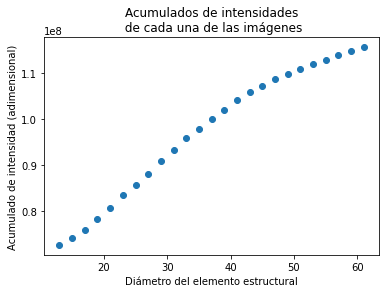

In [29]:
plt.scatter(b_sizes, values[:-1]);
plt.title("Acumulados de intensidades\n \
de cada una de las imágenes")
plt.xlabel("Diámetro del elemento estructural")
plt.ylabel("Acumulado de intensidad (adimensional)")
plt.show()

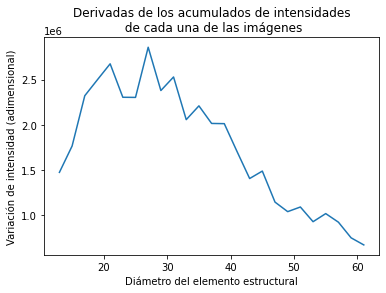

In [26]:
plt.plot(b_sizes, derivatives);
plt.title("Derivadas de los acumulados de intensidades\n \
de cada una de las imágenes")
plt.xlabel("Diámetro del elemento estructural")
plt.ylabel("Variación de intensidad (adimensional)")
plt.show()

A continuación, se detectan los picos para el histograma los cuales corresponden a los tamaños de los elementos estructurales.

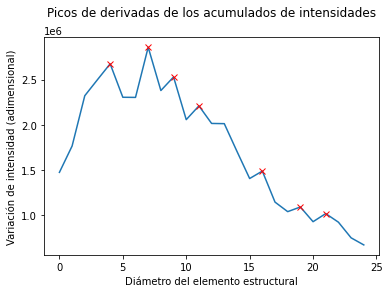

In [33]:
std_dev = np.sqrt(np.var(derivatives))
#print(derivatives)
peaks = signal7w7.find_peaks(x = derivatives)

plt.plot(derivatives)
for peak in peaks[0]:
    plt.plot(peak, derivatives[peak], 'x', color='red')

plt.title("Picos de derivadas de los acumulados de intensidades\n")
plt.xlabel("Diámetro del elemento estructural")
plt.ylabel("Variación de intensidad (adimensional)")
plt.show()

In [16]:
b_sizes[peaks[0]]

array([21, 27, 31, 35, 45, 51, 55])

Por último, se muestra el resultado de la detección de texturas con los picos del histograma de diferencias. Es importante aclarar que para picos pares se utiliza el número impar siguiente como elemento estrcutural.

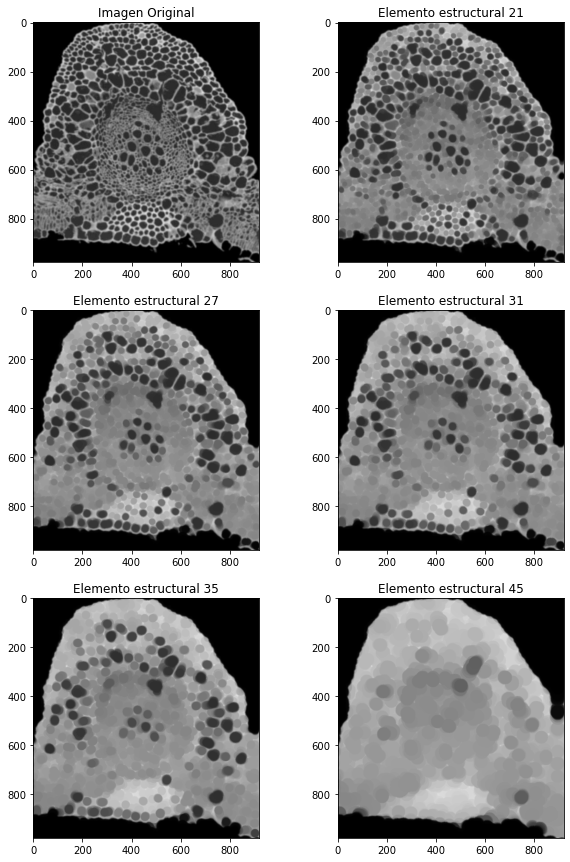

In [17]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10,15))
c = 0
ax1.imshow(img, cmap='gray')
ax1.set_title('Imagen Original')
for peak in  peaks[0]:
    
    if c == 0: title, ax= 'Elemento estructural '+str(b_sizes[peak]), ax2
    elif c==1: title, ax= 'Elemento estructural '+str(b_sizes[peak]), ax3
    elif c==2: title, ax= 'Elemento estructural '+str(b_sizes[peak]), ax4
    elif c==3: title, ax= 'Elemento estructural '+str(b_sizes[peak]), ax5
    elif c==4: title, ax= 'Elemento estructural '+str(b_sizes[peak]), ax6
 
    # b = gen_ones_circle(peak)
    #img_copy = granularidad(img, b)
    ax.imshow(imgs[peak], cmap='gray')
    ax.set_title(title)
    c += 1

In [40]:
def plot_segments(og_img: np.array,
                  processed_imgs: list,
                  b_size: np.array,
                  peaks: np.array,
                  std_multiplier = 1.0):
    
    """
    og_img:         Imagen original.
    processed_imgs: Lista de imagenes a las que se les ha aplicado
                    granularidad con un elemento estructural.
    b_size:         Vector de los tamaños de b. 
    peaks:          Vector con los indices de b que corresponden a un pico.
    std_multiplier: Para hacer la imagen se usa un umbral para detectar cambios
                    el umbral es la desviación estándar, el std_multiplier es un
                    float que multiplica a esa desviación estándar y que entre
                    más grande sea, más difícil hará para considerar una diferencia
                    como un cambio.
    """

    # pasa la imagen en escala de grises 
    # a su versión en rgb
    img_rgb  = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # numero de filas y columnas para el plot
    nrows = peaks.shape[0]
    ncols = 3
    
    # crea el plot
    fig , axs = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(10,20), dpi=200)
    fig.tight_layout()
    fig.tight_layout(pad=3.0)

    # matriz para guardar la imagen previa
    prev_img = img_rgb[:,:,0].astype('float32')
    
    # contador de la fila en la que se está
    # es para hacer el display
    count = 0
    
    for peak in peaks:
        
        # hace la resta para encontrar la diferencia entre un filtro
        # y otro
        operation = imgs[peak].astype('float32')  - prev_img
        
        # obtiene la desviación estándar de los datos en la matriz
        # para filtrar a partir de los valores de desviación estándar
        std = np.sqrt(np.var(operation))
        
        # actualiza la imagen previa 
        # con la del último filtro usado
        prev_img = imgs[peak].astype('float32')          
        
        # copia la imagen original para resaltarle 
        # en rojo las cosas que cambian
        im_copy = copy.deepcopy(img_rgb)
        
        # resalta las variaciones que son más fuertes que 
        # (std * std_multiplier)
        im_copy[:,:,0][operation >= std*std_multiplier] = 255
         
        axs[count, 0].imshow(img, cmap = 'gray')
        axs[count, 0].set_title("Imagen original")
        
        axs[count, 1].imshow(imgs[peak], cmap = 'gray')
        axs[count, 1].set_title("Imagen filtrada e.\n estruct. diametro: " +
                                str(b_sizes[peak])) 
        
        axs[count, 2].imshow(im_copy)
        axs[count, 2].set_title("Segmentos detectados\n de diametro: " +
                                str(b_sizes[peak])) 
        count = count + 1
        
        # actualiza la imagen acumulada
        #cumm_img = operation
    
    plt.show()
    

**Ahora resaltamos los segmentos en la imagen**

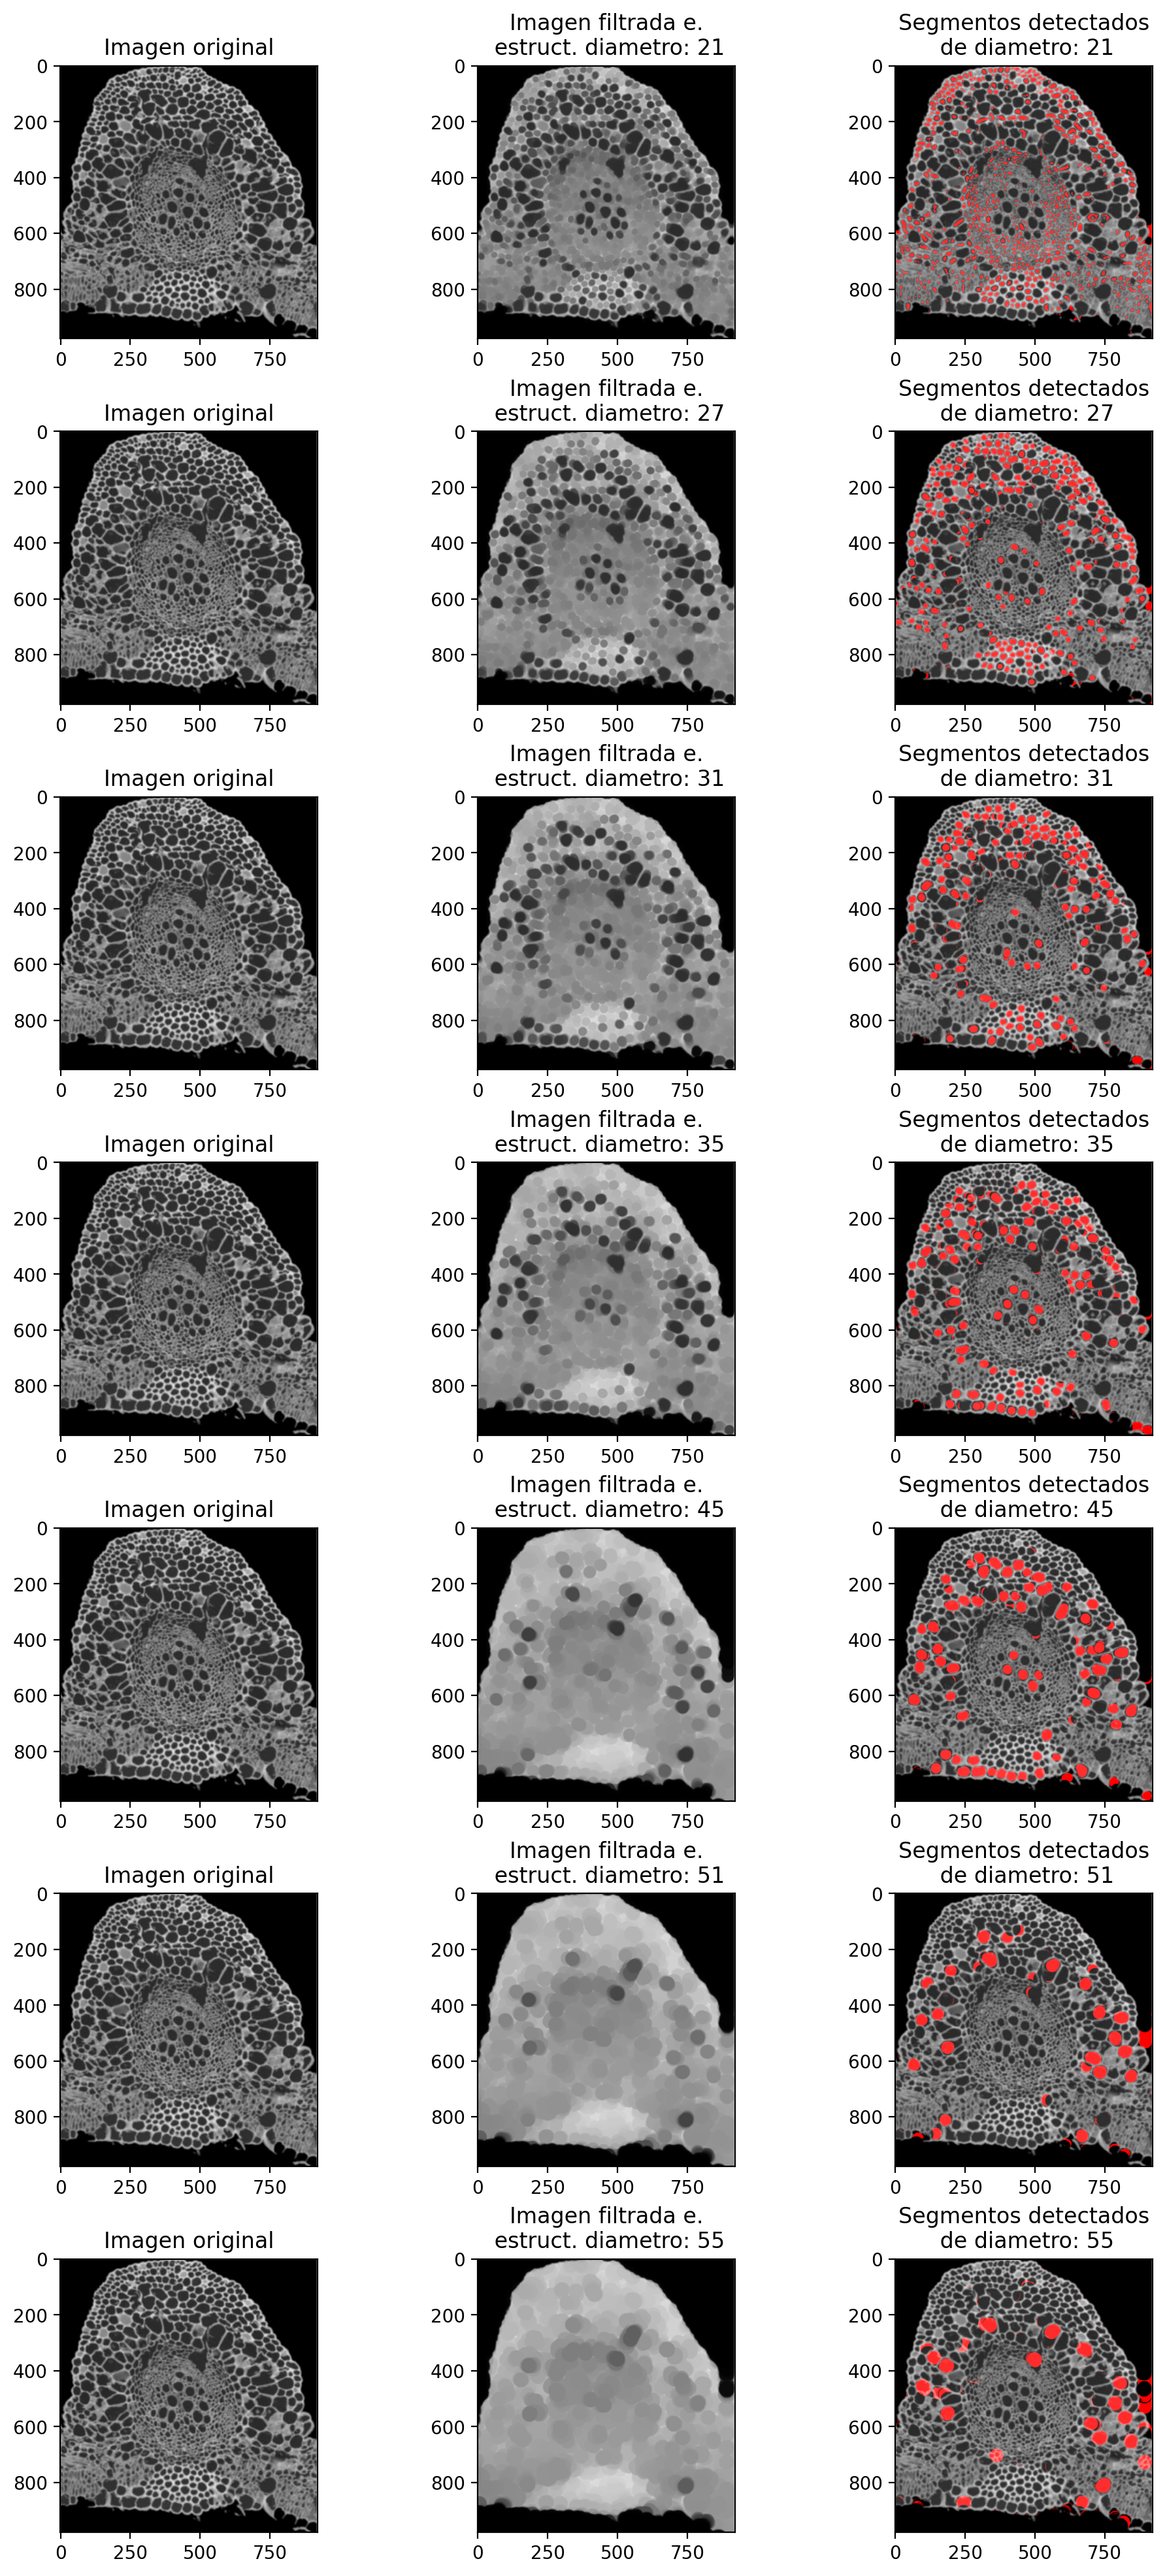

In [41]:
plot_segments(og_img = img, 
              processed_imgs = imgs,
              b_size= b_sizes,
              peaks = peaks[0], 
              std_multiplier = 2.2) 